# Step 1: Extract road network
This notebook will explore the nature of road networks extracted from OSM/Overture

In [ ]:
import os, sys
import overturemaps

import geopandas as gpd

import GOSTnets as gn
import GOSTnets.conversion_utils as cu

from GOSTnets.load_osm import OSM_to_network #Supports converting OSM data to GOSTnets network format

%load_ext autoreload
%autoreload 2


# Step 1a: Extract Road Network from OpenStreetMap (OSM)


## Download data and set filepaths
We will use the `osm.pbf` file for the entire country of Iceland. You can download the file from [Geofabrik](https://download.geofabrik.de/europe/iceland.html), if you didn't download it from the GOSTnets repository "tutorial_data" folder.
Once you have downloaded the file, set the filepath to the .osm.pbf file, this can be a relative or absolute path.
We demonstrate construction of a relative file path using the `os.path` module to define a relative path to the "tutorial_data" folder.

In [3]:
pth = "./"  # change this path to your working folder
fil = r"iceland-latest.osm.pbf"  # download this file from geofabrik: http://download.geofabrik.de/europe/iceland.html.

# be sure to place the .osm.pbf file in the 'tutorial data' folder.
f = os.path.join(pth, "tutorial_data", fil)

In [ ]:
# check if the file exists, raise an exception if it does not
if os.path.isfile(f):
    print("File found.")
else:
    raise Exception("File not found.")
# print the file path
print(f)

## Load the OSM data as a GOSTnets object

GOSTNets can load OSM data as a special 'OSM_to_network' object.
This object gets initialized with both a copy of the OSM file itself and the roads extracted from the OSM file in a GeoPandas DataFrame. 
This DataFrame is a property of the object called 'roads_raw' and is the starting point for our network.

In [29]:
# convert the .osm.pbf file to a GOSTnets object
iceland = OSM_to_network(f)

c:\WBG\Anaconda3\envs\gostnets\Lib\site-packages\osgeo\gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


skipping over reading other tags of osm_id: 5096419
skipping over reading other tags of osm_id: 5096423
skipping over reading other tags of osm_id: 5096426
skipping over reading other tags of osm_id: 7997603
skipping over reading other tags of osm_id: 16618981
skipping over reading other tags of osm_id: 25752609
skipping over reading other tags of osm_id: 38290957
skipping over reading other tags of osm_id: 48320149
skipping over reading other tags of osm_id: 48321029
skipping over reading other tags of osm_id: 48321051
skipping over reading other tags of osm_id: 48321052
skipping over reading other tags of osm_id: 48321062
skipping over reading other tags of osm_id: 48321063
skipping over reading other tags of osm_id: 48321123
skipping over reading other tags of osm_id: 48321136
skipping over reading other tags of osm_id: 48321139
skipping over reading other tags of osm_id: 48321445
skipping over reading other tags of osm_id: 80172077
skipping over reading other tags of osm_id: 117627

In [30]:
# display the first 5 rows of the extracted dataframe of the roads network
iceland.roads_raw.head()

,osm_id,infra_type,one_way,geometry
0,2818432,path,False,"LINESTRING (-16.87492 65.61337, -16.87472 65.6..."
1,2818434,path,False,"LINESTRING (-16.87107 65.59977, -16.86998 65.5..."
2,2818477,unclassified,False,"LINESTRING (-16.9174 65.61072, -16.91708 65.61..."
3,2837331,path,False,"LINESTRING (-16.5134 66.00186, -16.51331 66.00..."
4,2837332,service,False,"LINESTRING (-16.51283 66.00156, -16.51272 66.0..."


In [31]:
# show the different road types and counts
iceland.roads_raw.infra_type.value_counts()

infra_type
service           25165
footway           15868
track              9953
residential        9519
path               7292
tertiary           4573
unclassified       2997
secondary          2898
primary            2353
trunk              1461
steps               793
trunk_link          283
platform            269
bridleway           247
primary_link        170
cycleway            124
secondary_link       95
living_street        89
tertiary_link        47
motorway             40
motorway_link        36
construction         34
pedestrian           24
proposed             16
road                 14
raceway              12
corridor              8
bus_stop              7
planned               2
rest_area             2
emergency_bay         1
abandoned             1
services              1
Name: count, dtype: int64

### Define the accepted road types list

We define a list of the types of roads from the above that we consider acceptable for our road network.
This list is used to filter the roads DataFrame to only include the types specified.

In [4]:
accepted_road_types = [
    "residential",
    "unclassified",
    "track",
    "service",
    "tertiary",
    "road",
    "secondary",
    "primary",
    "trunk",
    "primary_link",
    "trunk_link",
    "tertiary_link",
    "secondary_link",
]

### Filter the roads DataFrame

We call the `filterRoads` method and pass it a list of acceptable road types.
Then we can look at the infrastructure types in the filtered roads DataFrame (similar to what was done above), except now we have filtered the roads to only include the types we want.

In [33]:
iceland.filterRoads(acceptedRoads=accepted_road_types)

In [34]:
iceland.roads_raw.infra_type.value_counts()

infra_type
service           25165
track              9953
residential        9519
tertiary           4573
unclassified       2997
secondary          2898
primary            2353
trunk              1461
trunk_link          283
primary_link        170
secondary_link       95
tertiary_link        47
road                 14
Name: count, dtype: int64

## Clip the roads to a polygon

Here, we import a shapefile for our area of interest. We want to make a map of Reykjavik, Iceland. We clip the extent of the country file to just the area around the capital (rek2.shp) below using standard GeoPandas functions:

In [35]:
# read the shapefile for the clip area
clip_shp = gpd.read_file(os.path.join(pth, "tutorial_data", "rek2.shp"))
clip_shp = clip_shp.to_crs(4326)
clip_shp_obj = clip_shp.geometry.iloc[0]

<Axes: >

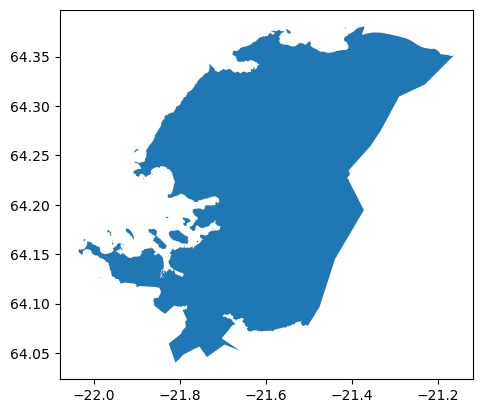

In [36]:
# visualize the clip area
clip_shp.plot()

### Check to ensure some roads intersect the AOI

We check to see everything lines up by running intersect and counting the True / False returns.
The count of the True values are the number of roads that intersect the AOI

In [37]:
# intersects is a Shapely function that returns True if the boundary or interior of the object intersect in any way with those of the other
iceland.roads_raw.geometry.intersects(clip_shp_obj).value_counts()

False    48689
True     10839
Name: count, dtype: int64

Next we remove any roads that don't intersect the capital area, by modifying the `roads_raw` DataFrame contained within the `OSM_to_network` object 

In [38]:
iceland.roads_raw = iceland.roads_raw.loc[
    iceland.roads_raw.geometry.intersects(clip_shp_obj) == True  # noqa: E712
]

In [39]:
# reprint the intersects value counts (should only be True now)
iceland.roads_raw.geometry.intersects(clip_shp_obj).value_counts()

True    10839
Name: count, dtype: int64

In [40]:
iceland.generateRoadsGDF()
# view the first 5 rows of the newly created roads GeoDataFrame
iceland.roadsGPD.head()

Processing 0 of 10839
seconds elapsed: 0.0011148452758789062
Processing 1000 of 10839
seconds elapsed: 1.182178020477295
Processing 2000 of 10839
seconds elapsed: 2.1072118282318115
Processing 3000 of 10839
seconds elapsed: 2.9456710815429688
Processing 4000 of 10839
seconds elapsed: 3.787166118621826
Processing 5000 of 10839
seconds elapsed: 4.709049940109253
Processing 6000 of 10839
seconds elapsed: 5.696442604064941
Processing 7000 of 10839
seconds elapsed: 6.511017084121704
Processing 8000 of 10839
seconds elapsed: 7.2971813678741455
Processing 9000 of 10839
seconds elapsed: 8.157870054244995
Processing 10000 of 10839
seconds elapsed: 8.96885895729065


,Wkt,osm_id,infra_type,one_way,id,key,length,u,v
0,"LINESTRING (-22.02815 64.15258, -22.02901 64.1...",4342807,service,True,1,edge_1,0.098079,"(-22.0281534, 64.152579)","(-22.0284658, 64.1525149)"
1,"LINESTRING (-22.02847 64.15251, -22.02815 64.1...",4342807,service,True,2,edge_2,0.016799,"(-22.0284658, 64.1525149)","(-22.0281534, 64.152579)"
2,"LINESTRING (-22.01332 64.16252, -22.0131 64.16...",4342928,tertiary,False,3,edge_3,0.119353,"(-22.0133192, 64.1625235)","(-22.010918, 64.1623222)"
3,"LINESTRING (-22.01092 64.16232, -22.01073 64.1...",4342928,tertiary,False,4,edge_4,0.131528,"(-22.010918, 64.1623222)","(-22.0084819, 64.1618377)"
4,"LINESTRING (-22.00848 64.16184, -22.00802 64.1...",4342928,tertiary,False,5,edge_5,0.117113,"(-22.0084819, 64.1618377)","(-22.0063239, 64.1614521)"


In [41]:
iceland.initialReadIn()

__Save the graph object to file__

We save this graph object down to file using `gn.save()`. The save function produces three outputs: a node GeoDataFrame as a CSV, an edge GeoDataFrame as a CSV, and a graph object saved as a pickle.

In [ ]:
gn.save(iceland.network, "iceland_unclean", os.path.join(pth, "tutorial_outputs"))

## 1b. Download road network from Overture
The [Overture Maps Foundation](https://overturemaps.org/) combines a foundation of OpenStreetMap data combined with various secondary datasets that cannot be imported into OSM.

<Axes: >

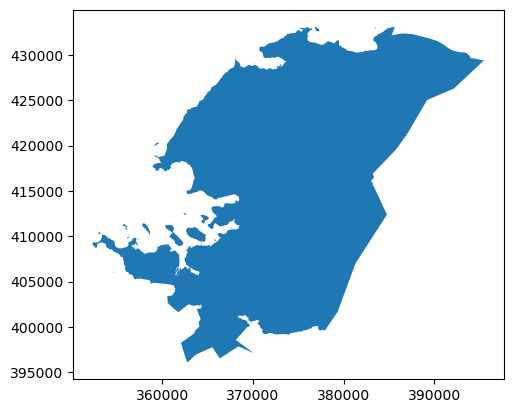

In [5]:
aoi = gpd.read_file(os.path.join(pth, "tutorial_data", "rek2.shp"))
aoi.plot()

In [ ]:
# The overture maps transport network extraction requires a bounding box in WGS84 (EPSG:4326) format
bbox = aoi.to_crs(epsg=4326).total_bounds.tolist()
# Extract the transport network within the bounding box
transport = overturemaps.record_batch_reader("segment", bbox, release="2025-12-17.0").read_all()
transport_df = gpd.GeoDataFrame.from_arrow(transport)
transport_df.crs = 4326
transport_df = transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]]

orig_cols = transport_df.columns
transport_df = gpd.sjoin(transport_df, aoi.to_crs(4326), how="inner")
transport_df = transport_df.loc[:, orig_cols]
# filter to accept only accepted road types
transport_df = transport_df.loc[transport_df['class'].isin(accepted_road_types)]


In [ ]:
G = cu.convert_roads_to_nx(transport_df, unq_id='id', infra_field='class')

Processing 0 of 1000
seconds elapsed: 0.0006527900695800781


__Save the graph object to file__

We save this graph object down to file using `gn.save()`. The save function produces three outputs: a node GeoDataFrame as a CSV, an edge GeoDataFrame as a CSV, and a graph object saved as a pickle.

In [ ]:
gn.save(G, "iceland_overture_sample", os.path.join(pth, "tutorial_outputs"))

Move on to [Step 2](Step_2-Clean_Network.ipynb) to see how we clean up this rough network.